# Fitting GLMs with spike history

Adapted from https://github.com/pillowlab/GLMspiketraintutorial_python/blob/main/tutorial1_PoissonGLM.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cebra
import cebra.datasets
from scipy.io import loadmat
import scipy.linalg
from week5_utils import HippocampusDataset, GLMModel

data = HippocampusDataset()

In [2]:
from scipy.linalg import hankel

def build_design_matrix(stim, filter_size):
    padded_stim = np.hstack((np.zeros(filter_size-1), stim))   # pad early bins of stimulus with zero
    design_mat = scipy.linalg.hankel(padded_stim[:-filter_size+1], stim[-filter_size:])
    return design_mat

def build_design_matrix_with_history(stim, spikes, filter_size, history_timesteps):
    # Build design matrix as for part I
    design_mat_stim = build_design_matrix(stim, filter_size=filter_size)

    # Build spike-history design matrix
    padded_spikes = np.hstack((np.zeros(history_timesteps), spikes_binned[:-1]))
    # SUPER important: note that this doesn't include the spike count for the
    # bin we're predicting? The spike train is shifted by one bin (back in
    # time) relative to the stimulus design matrix
    design_mat_spikes = hankel(padded_spikes[:-history_timesteps+1], padded_spikes[-history_timesteps:])

    return np.concatenate((design_mat_stim, design_mat_spikes), axis=1)


cell_idx = 51
spikes_binned = data.get_neuron_spikes(cell_idx)
stim = data.position
design_matrix = build_design_matrix_with_history(stim, spikes_binned, filter_size = 25, history_timesteps=20)

<Figure size 640x480 with 0 Axes>

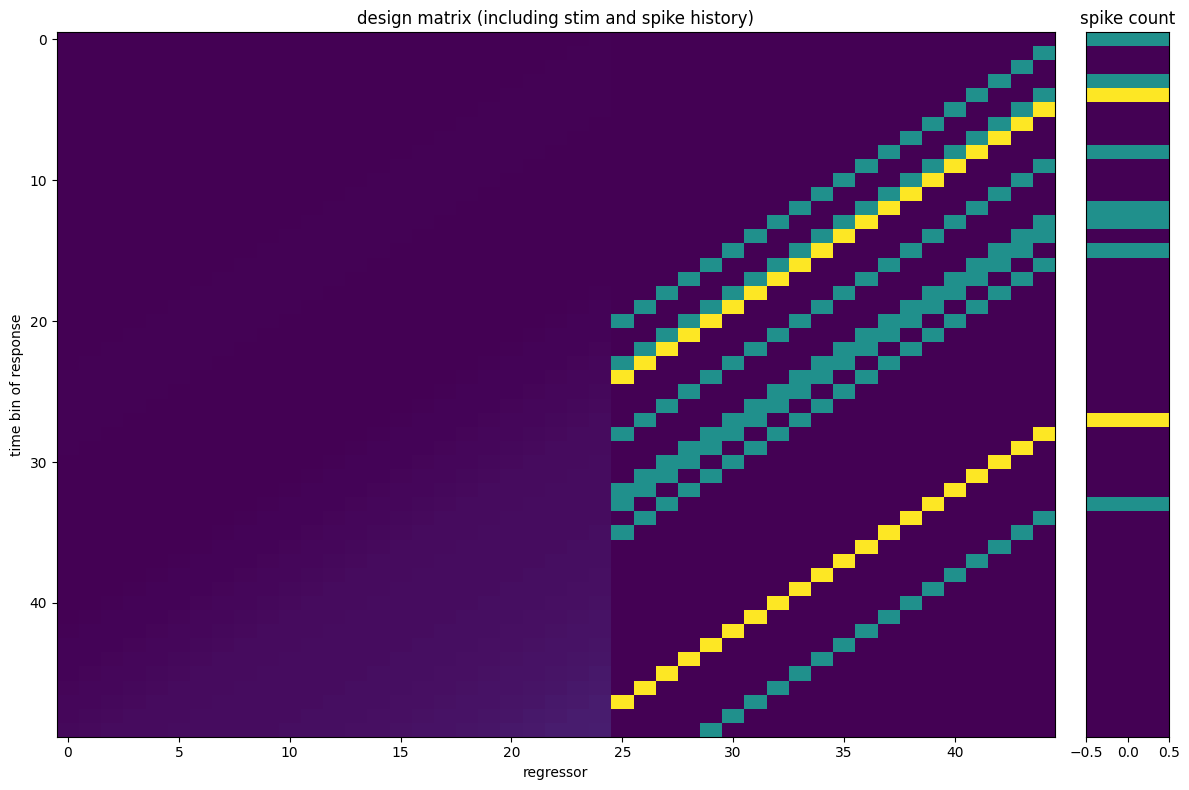

In [3]:
plt.clf()
fig = plt.figure(figsize=[12,8])
plt.subplot(1,10,(1,9))
plt.imshow(design_matrix[:50], aspect='auto', interpolation='nearest')
plt.xlabel('regressor')
plt.ylabel('time bin of response')
plt.title('design matrix (including stim and spike history)')
plt.subplot(1,10,10)
plt.imshow(spikes_binned[:50,np.newaxis], aspect='auto', interpolation='nearest')
plt.yticks(ticks=[], labels=[])
plt.title('spike count')
plt.tight_layout()
plt.show()

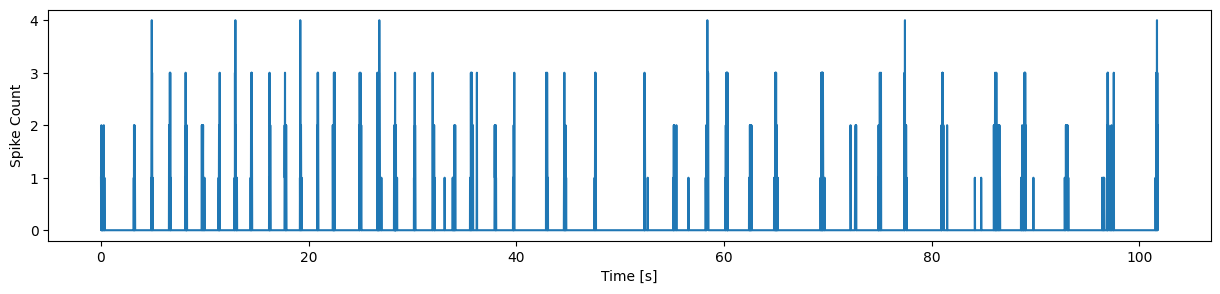

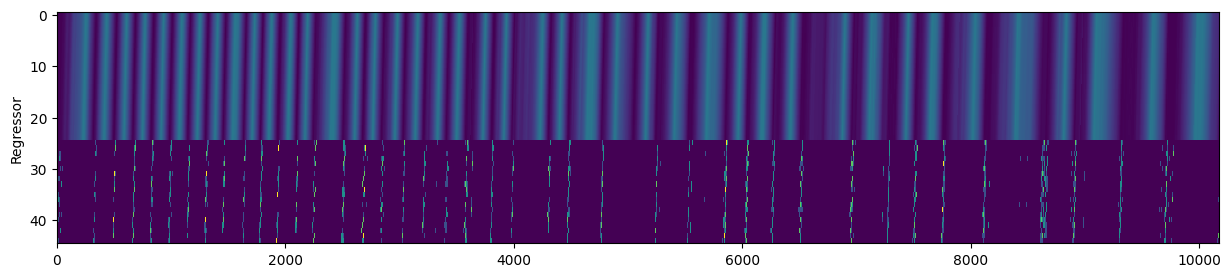

In [4]:
cell_idx = 51
spikes_binned = data.get_neuron_spikes(cell_idx)
stim = data.position
design_matrix = build_design_matrix_with_history(stim, spikes_binned, filter_size = 25, history_timesteps=20)

plt.figure(figsize=(15,3))
plt.plot(data.time, spikes_binned)
plt.xlabel("Time [s]")
plt.ylabel("Spike Count")
plt.show()

plt.figure(figsize=(15,3))
plt.imshow(design_matrix.T, aspect = "auto", interpolation="none")
plt.ylabel("Regressor")
plt.show()

Score, w/o history 0.1449798725785274
Score, w/ history  0.25723383100135844


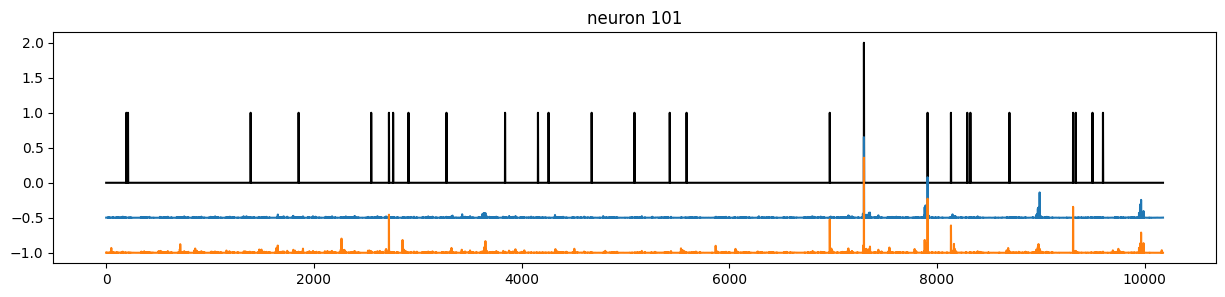

In [19]:
cell_idx = 101
spikes = data.get_neuron_spikes(cell_idx)
stim = data.position

design_matrix_standard = build_design_matrix(stim, filter_size = 50)
design_matrix_history = build_design_matrix_with_history(stim, spikes_binned, filter_size = 50, history_timesteps=50)

glm = GLMModel()
glm.fit(design_matrix_standard, spikes)
pred_wo_history = glm.predict(design_matrix_standard)
print("Score, w/o history", glm.score())

glm.fit(design_matrix_history, spikes)
pred_w_history = glm.predict(design_matrix_history)
print("Score, w/ history ", glm.score())

plt.figure(figsize=(15,3))
plt.plot(spikes, c = "black")
plt.plot(pred_wo_history - .5)
plt.plot(pred_w_history - 1.0)
plt.title(f"neuron {cell_idx}")
plt.show()